### Import Packages

In [1]:
import pandas as pd
import numpy as np
import torch as t
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

### Import Data

In [3]:
data = pd.read_csv("../data/compas-scores-two-years.csv")

In [4]:
data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


## Data Preprocessing

In [5]:
data_extract = data[['c_charge_degree','race','age_cat','score_text','sex','priors_count','days_b_screening_arrest','decile_score','is_recid','two_year_recid','c_jail_in','c_jail_out']]
data_extract = data_extract[data_extract['days_b_screening_arrest'] <=30]
data_extract = data_extract[data_extract['days_b_screening_arrest'] >= -30]
data_extract = data_extract[data_extract['is_recid'] != -1]
data_extract = data_extract[data_extract['c_charge_degree'] != 'O']
data_extract = data_extract[data_extract['score_text'] != 'N/A']

data_extract['c_jail_out'] =  data_extract['c_jail_out'].apply(pd.to_datetime)
data_extract['c_jail_in'] = data_extract['c_jail_in'].apply(pd.to_datetime)
data_extract['length_of_stay'] = data_extract['c_jail_out'] - data_extract['c_jail_in']
data_extract['length_of_stay'] = data_extract['length_of_stay'].dt.days
data_extract['length_of_stay'] = data_extract.length_of_stay.apply(lambda x:'greater than 100 days'  if x >100 else ('10-100 days' if x >10 else 'less than 10 days'))


categorical_variabls = ["c_charge_degree","race","age_cat","score_text",'is_recid','two_year_recid','length_of_stay']
for var in categorical_variabls:
    data_extract[var] = data_extract[var].astype('category')
    data_extract[var+"_code"] = data_extract[var].cat.codes
data_extract_african_america = data_extract[(data_extract['race']=='African-American')]
data_extract_caucasian = data_extract[(data_extract['race']=='Caucasian')]
data_extract_african_america = data_extract_african_america[['two_year_recid_code','is_recid_code','score_text_code','age_cat_code','race_code','c_charge_degree_code','length_of_stay_code','priors_count','days_b_screening_arrest','decile_score']]
data_extract_caucasian = data_extract_caucasian[['two_year_recid_code','is_recid_code','score_text_code','age_cat_code','race_code','c_charge_degree_code','length_of_stay_code','priors_count','days_b_screening_arrest','decile_score']]


In [6]:
data_extract_african_america.head()

,two_year_recid_code,is_recid_code,score_text_code,age_cat_code,race_code,c_charge_degree_code,length_of_stay_code,priors_count,days_b_screening_arrest,decile_score
1,1,1,1,0,0,0,2,0,-1.0,3
2,1,1,1,2,0,0,2,4,-1.0,4
11,1,1,2,2,0,1,2,3,0.0,6
13,0,0,1,0,0,0,2,0,-1.0,4
15,1,1,1,0,0,0,2,7,22.0,3


In [8]:
data_extract_caucasian.head()

,two_year_recid_code,is_recid_code,score_text_code,age_cat_code,race_code,c_charge_degree_code,length_of_stay_code,priors_count,days_b_screening_arrest,decile_score
6,1,1,2,0,2,0,2,14,-1.0,6
8,0,0,1,0,2,1,2,0,-1.0,1
10,0,0,1,0,2,0,2,0,-1.0,4
12,0,0,1,0,2,1,2,0,0.0,1
14,1,1,1,1,2,0,0,1,-20.0,1


### Split the data into train, test and validation with the proportion of training: validation: testing = 5: 1: 1

In [9]:
train_african_america, validate_african_america, test_african_america = np.split(data_extract_african_america.sample(frac=1, random_state=42), 
                       [int(.72*len(data_extract_african_america)), int(.86*len(data_extract_african_america))])
x_train_african_america = t.tensor(train_african_america.drop(['two_year_recid_code'],1).values)
y_train_african_america = t.tensor(train_african_america['two_year_recid_code'].values)
y_train_african_america = y_train_african_america.reshape(y_train_african_america.shape[0],1)
x_val_african_america = t.tensor(validate_african_america.drop(['two_year_recid_code'],1).values)
y_val_african_america = t.tensor(validate_african_america['two_year_recid_code'].values)
y_val_african_america = y_val_african_america.reshape(y_val_african_america.shape[0],1)
x_test_african_america = t.tensor(test_african_america.drop(['two_year_recid_code'],1).values)
y_test_african_america = t.tensor(test_african_america['two_year_recid_code'].values)
y_test_african_america = y_test_african_america.reshape(y_test_african_america.shape[0],1)

<ipython-input-9-c13f0df19183>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train_african_america = t.tensor(train_african_america.drop(['two_year_recid_code'],1).values)
<ipython-input-9-c13f0df19183>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_val_african_america = t.tensor(validate_african_america.drop(['two_year_recid_code'],1).values)
<ipython-input-9-c13f0df19183>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test_african_america = t.tensor(test_african_america.drop(['two_year_recid_code'],1).values)


In [10]:
train_caucasian, validate_caucasian, test_caucasian = np.split(data_extract_caucasian.sample(frac=1, random_state=42), 
                       [int(.72*len(data_extract_caucasian)), int(.86*len(data_extract_caucasian))])
x_train_caucasian = t.tensor(train_caucasian.drop(['two_year_recid_code'],1).values)
y_train_caucasian = t.tensor(train_caucasian['two_year_recid_code'].values)
y_train_caucasian = y_train_caucasian.reshape(y_train_caucasian.shape[0],1)
x_val_caucasian = t.tensor(validate_caucasian.drop(['two_year_recid_code'],1).values)
y_val_caucasian = t.tensor(validate_caucasian['two_year_recid_code'].values)
y_val_caucasian = y_val_caucasian.reshape(y_val_caucasian.shape[0],1)
x_test_caucasian = t.tensor(test_caucasian.drop(['two_year_recid_code'],1).values)
y_test_caucasian = t.tensor(test_caucasian['two_year_recid_code'].values)
y_test_caucasian = y_test_caucasian.reshape(y_test_caucasian.shape[0],1)


<ipython-input-10-65548961afdc>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train_caucasian = t.tensor(train_caucasian.drop(['two_year_recid_code'],1).values)
<ipython-input-10-65548961afdc>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_val_caucasian = t.tensor(validate_caucasian.drop(['two_year_recid_code'],1).values)
<ipython-input-10-65548961afdc>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test_caucasian = t.tensor(test_caucasian.drop(['two_year_recid_code'],1).values)


### Baseline Model: Logistic Regression

In [11]:
class LogisticRegression(nn.Module):
    def __init__(self,data):
        super(LogisticRegression, self).__init__()
        self.w = nn.Linear(data.shape[1], out_features=1, bias=True)
        self.sigmod = nn.Sigmoid()
    def forward(self,x):
        w = self.w(x)
        output = self.sigmod(w)
        return output

In [12]:
x_train = t.cat((x_train_african_america, x_train_caucasian), 0)
y_train = t.cat((y_train_african_america, y_train_caucasian), 0)
x_val = t.cat((x_val_african_america, x_train_caucasian), 0)
y_val = t.cat((y_val_african_america, y_train_caucasian), 0)

In [13]:
model = LogisticRegression(x_train)
criterion = nn.BCELoss(reduction='sum')
epochs = 200
optimizer = t.optim.Adam(list(model.parameters()), 0.01, weight_decay=1e-5)
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(x_train.float())
    train_loss = criterion(output, y_train.float())
    train_losses.append(train_loss.item())
    train_loss.backward()
    optimizer.step()
    model.eval() 
    output = model(x_val.float())
    val_loss = criterion(output, y_val.float())
    val_losses.append(val_loss.item())

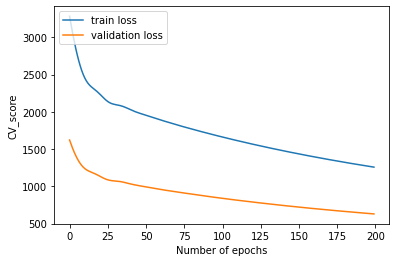

In [17]:
plt.plot(list(range(200)),train_losses, label="train loss")
plt.plot(list(range(200)),val_losses, label="validation loss")
plt.legend(loc="upper left")
plt.xlabel('Number of epochs')
plt.ylabel('CV_score')
plt.show()

In [28]:
model.eval()
y_am_pred = (model(x_test_african_america.float()) >=0.5)
y_cau_pred = (model(x_test_caucasian.float()) >=0.5)
accuracy  = (t.sum(y_am_pred.flatten() == y_test_african_america.flatten()) + t.sum(y_cau_pred.flatten() == y_test_caucasian.flatten())) / (x_test_african_america.shape[0]+x_test_caucasian.shape[0])
accu_am  = t.sum(y_am_pred.flatten() == y_test_african_america.flatten()) / x_test_african_america.shape[0]
accu_caucasian  = t.sum(y_cau_pred.flatten() == y_test_caucasian.flatten()) / x_test_caucasian.shape[0]
calibration = abs(accu_caucasian - accu_am)

In [29]:
accuracy # whole dataset

tensor(0.9541)

In [30]:
calibration  # diff of af and caucas

tensor(0.0369)

### Prejudice Remover Regularizer

In [31]:
class PrejudictRemoverLoss():
    def __init__(self, eta=1.0):
        super(PrejudictRemoverLoss, self).__init__()
        self.eta = eta  
    def forward(self,output_caucasian,output_african_america):
        N_caucasian = t.tensor(output_caucasian.shape[0])
        N_african_america   = t.tensor(output_african_america.shape[0])
        Dxisi = t.stack((N_african_america,N_caucasian),axis=0) 
        # Pr[y|s]
        y_pred_caucasian = t.sum(output_caucasian)   # (16)
        y_pred_african_america = t.sum(output_african_america)
        p_ys = t.stack((y_pred_african_america,y_pred_caucasian),axis=0) / Dxisi
        # Pr[y]
        p = t.cat((output_caucasian,output_african_america),0) #(17)
        p_y = t.sum(p) / (x_train_caucasian.shape[0]+x_train_african_america.shape[0])  
        # P(siyi)
        p_s1y1 = t.log(p_ys[1]) - t.log(p_y)  # (15)
        p_s1y0 = t.log(1-p_ys[1]) - t.log(1-p_y)
        p_s0y1 = t.log(p_ys[0]) - t.log(p_y)
        p_s0y0 = t.log(1-p_ys[0]) - t.log(1-p_y)
        # PI
        pi_s1y1 = output_caucasian * p_s1y1   # (14)
        pi_s1y0 =(1- output_caucasian) * p_s1y0
        pi_s0y1 = output_african_america * p_s0y1
        pi_s0y0 = (1- output_african_america )* p_s0y0
        pi = t.sum(pi_s1y1) + t.sum(pi_s1y0) + t.sum(pi_s0y1) + t.sum(pi_s0y0)
        pi = self.eta * pi
        return pi

In [34]:
model_african_america = LogisticRegression(x_train_african_america)
model_caucasian = LogisticRegression(x_train_caucasian)
criterion = nn.BCELoss(reduction='sum')
pi = PrejudictRemoverLoss()
epochs = 200
optimizer = t.optim.Adam(list(model_caucasian.parameters())+ list(model_african_america.parameters()), 0.01, weight_decay=1e-5)
train_losses = []
val_losses = []
for epoch in range(epochs):
    model_african_america.train()
    model_caucasian.train()
    optimizer.zero_grad()
    output_african_america = model_african_america(x_train_african_america.float())
    output_caucasian = model_caucasian(x_train_caucasian.float())
    logloss = criterion(output_african_america, y_train_african_america.float())+ criterion(output_caucasian, y_train_caucasian.float())
    pi_loss = pi.forward(output_african_america,output_caucasian)
    train_loss = pi_loss +logloss
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    model_african_america.eval() 
    model_caucasian.eval()
    output_african_america = model_african_america(x_val_african_america.float())
    output_caucasian = model_caucasian(x_val_caucasian.float())
    logloss = criterion(output_african_america, y_val_african_america.float())+ criterion(output_caucasian, y_val_caucasian.float())
    pi_loss = pi.forward(output_african_america,output_caucasian)
    val_loss = pi_loss +logloss
    val_losses.append(val_loss.item())

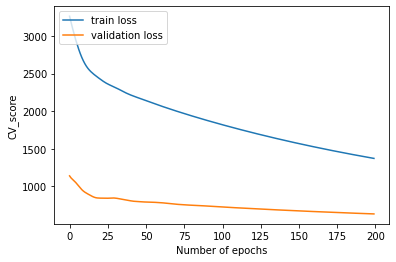

In [35]:
plt.plot(list(range(200)),train_losses, label="train loss")
plt.plot(list(range(200)),val_losses, label="validation loss")
plt.legend(loc="upper left")
plt.xlabel('Number of epochs')
plt.ylabel('CV_score')
plt.show()

In [36]:
y_am_pred = (model_african_america(x_test_african_america.float()) >=0.5)
y_cau_pred = (model_caucasian(x_test_caucasian.float()) >=0.5)
accuracy  = (t.sum(y_am_pred.flatten() == y_test_african_america.flatten()) + t.sum(y_cau_pred.flatten() == y_test_caucasian.flatten())) / (x_test_african_america.shape[0]+x_test_caucasian.shape[0])
accu_am  = t.sum(y_am_pred.flatten() == y_test_african_america.flatten()) / x_test_african_america.shape[0]
accu_caucasian  = t.sum(y_cau_pred.flatten() == y_test_caucasian.flatten()) / x_test_caucasian.shape[0]
calibration = abs(accu_caucasian - accu_am)


In [37]:
accuracy

tensor(0.9311)

In [38]:
calibration

tensor(0.0301)